## Import Libraries

In [5]:
import ta
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from fredapi import Fred
from datetime import datetime
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

today = datetime.today().strftime('%Y-%m-%d')

## 0. 주가예측을 위한 범위 설정
주가예측을 진행하고 싶은 상장회사의 티커와, 시작일과 종료일을 지정해야 합니다.

이때 티커는 소문자로 입력해주어야 합니다.
또한, 시작일은 가급적 재무제표의 데이터를 높이기 위해 2013년 9월 이후로 해주는 것이 좋습니다.
만약 종료일을 오늘 날짜로 하고 싶다면, 종료일에 today만 입력해도 됩니다.

In [12]:
ticker = 'aapl' 
start_date = '2013-09-28'
end_date = '2023-10-09'

# 데이터 준비

# 1. Technical data - 주가 데이터 수집 및 보조지표 추가

In [7]:
stock_df = yf.download(ticker, start = start_date, end = end_date)

## 1.1. Simple Moving Average (SMA)
stock_df['MA5'] = stock_df['Adj Close'].rolling(window=5).mean()        # 5일 SMA
stock_df['MA20'] = stock_df['Adj Close'].rolling(window=20).mean()      # 20일 SMA
stock_df['MA60'] = stock_df['Adj Close'].rolling(window=60).mean()      # 60일 SMA
stock_df['MA120'] = stock_df['Adj Close'].rolling(window=120).mean()    # 120일 SMA

## 1.2. Exponential Moving Average (EMA)
stock_df['EMA5'] = stock_df['Adj Close'].ewm(span=5, adjust=False).mean()       # 5일 EMA
stock_df['EMA20'] = stock_df['Adj Close'].ewm(span=20, adjust=False).mean()     # 20일 EMA
stock_df['EMA60'] = stock_df['Adj Close'].ewm(span=60, adjust=False).mean()     # 60일 EMA
stock_df['EMA120'] = stock_df['Adj Close'].ewm(span=120, adjust=False).mean()   # 120일 EMA

## 1.3. Double Bollinger Bands indicator

# Central Line (20-day moving average)
stock_df['BOL_AVG'] = ta.volatility.bollinger_mavg(stock_df['Adj Close'])

# Double Bollinger Bands
stock_df['BOL_H1'] = stock_df['BOL_AVG'] + 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L1'] = stock_df['BOL_AVG'] - 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_H2'] = stock_df['BOL_AVG'] + stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L2'] = stock_df['BOL_AVG'] - stock_df['Adj Close'].rolling(window=20).std()

## 1.4. Relative Strength Index (RSI)
stock_df['RSI'] = ta.momentum.rsi(stock_df['Adj Close'])

## 1.5. Moving Average Convergence Divergence (MACD)
stock_df['MACD'] = ta.trend.macd(stock_df['Adj Close'])
stock_df['MACD_SIGNAL']= ta.trend.macd_signal(stock_df['Adj Close'])

## 1.6. On-Balance Volume (OBV)
stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Adj Close'], stock_df['Volume'])

stock_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA60,MA120,...,EMA120,BOL_AVG,BOL_H1,BOL_L1,BOL_H2,BOL_L2,RSI,MACD,MACD_SIGNAL,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2013-09-30,17.044643,17.202143,16.943214,17.026787,14.860144,260156400,NaN,NaN,NaN,NaN,...,14.860144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260156400
2013-10-01,17.087500,17.469286,17.084999,17.427143,15.209556,353883600,NaN,NaN,NaN,NaN,...,14.865919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,614040000
2013-10-02,17.343929,17.564285,17.276787,17.484285,15.259430,289184000,NaN,NaN,NaN,NaN,...,14.872423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,903224000
2013-10-03,17.518213,17.583929,17.169287,17.264643,15.067738,322753200,NaN,NaN,NaN,NaN,...,14.875652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580470800
2013-10-04,17.280714,17.307142,17.092857,17.251072,15.055888,258868400,15.090551,NaN,NaN,NaN,...,14.878631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321602400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,171.220001,174.300003,170.929993,173.750000,173.750000,52164500,171.608002,176.217001,182.575552,179.349299,...,176.117234,176.217001,185.163440,167.270562,180.690220,171.743781,44.066869,-2.583820,-2.314384,11078142400
2023-10-03,172.259995,173.630005,170.820007,172.399994,172.399994,49594600,171.695999,175.352000,182.309625,179.455438,...,176.055792,175.352000,181.808299,168.895702,178.580150,172.123851,41.822090,-2.520257,-2.355559,11028547800
2023-10-04,171.089996,174.210007,170.970001,173.660004,173.660004,53020300,172.342001,174.889500,182.073519,179.526702,...,176.016192,174.889500,180.307974,169.471027,177.598737,172.180264,44.655806,-2.341223,-2.352692,11081568100


# 2. Fundamental data - 경제지표 불러오기

In [13]:
adj_close_df = stock_df[['Adj Close']]

## 2.1. U.S. Treasury bond yields 
fred = Fred(api_key = '4c55d0ee6170369793707da4cba1b7be')
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)      # 2년 DGS
dgs5 = fred.get_series('DGS5', observation_start=start_date, observation_end=end_date)      # 5년 DGS
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)    # 10년 DGS

DGS = pd.concat([dgs2, dgs5,dgs10], axis=1)
DGS.columns = ['2-year', '5-year', '10-year']
DGS.index.name = 'Date'

## 2.2. U.S. long-short interest rate spread (10-year & 2-year)
T10Y2Y = fdr.DataReader('FRED:T10Y2Y', start_date, end_date)
T10Y2Y.index.name = 'Date'

## 2.3. Volatility Index (VIX)
VIX = fdr.DataReader('FRED:VIXCLS', start_date, end_date)
VIX.index.name = 'Date'

## 2.4. Unemployment Rate
Unemployment_Rate = fdr.DataReader('FRED:UNRATE', start_date, end_date)
Unemployment_Rate.index.name = 'Date'

## 2.5. Consumer Price Index (CPI)
CPI = fdr.DataReader('FRED:CPIAUCSL', start_date, end_date)
CPI.index.name = 'Date'

## 2.6. Federal funds rate
FEDFUNDS = fdr.DataReader('FRED:FEDFUNDS', start_date, end_date)
FEDFUNDS.index.name = 'Date'

## 2.7. Gross Domestic Product (GDP)
GDP = pd.DataFrame(fred.get_series('GDP',observation_start=start_date, observation_end = end_date),columns=['GDP'])
GDP.index.name = 'Date'

## Interpolation and Holt-Winters' Exponential Smoothing 

# DGS
# Linear interpolation up to the last date of the data
itp_df = DGS.resample('D').asfreq() 
itp_df = itp_df.interpolate(method='linear') 

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
stock_end_date = stock_df.index[-1]
forecast_steps = (pd.to_datetime(stock_end_date) - itp_df.index[-1]).days   
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

for column in itp_df.columns:
    model = ExponentialSmoothing(itp_df[column], trend='add', seasonal=None).fit() # Holt-Winters' Exponential Smoothing
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast

int_DGS = pd.concat([itp_df, forecast_df])

# Unemployment Rate
# Linear interpolation up to the last date of the data
itp_unrate = Unemployment_Rate.resample('D').asfreq()
itp_unrate = itp_unrate.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_unrate = (pd.to_datetime(stock_end_date) - itp_unrate.index[-1]).days 
forecast_df_unrate = pd.DataFrame(index=pd.date_range(itp_unrate.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_unrate = ExponentialSmoothing(itp_unrate['UNRATE'], trend='add', seasonal=None).fit()
forecast_unrate = model_unrate.forecast(steps=forecast_steps_unrate)
forecast_df_unrate['UNRATE'] = forecast_unrate

int_Unemployment_Rate = pd.concat([itp_unrate, forecast_df_unrate])

# CPI
# Linear interpolation up to the last date of the data
itp_CPI = CPI.resample('D').asfreq()
itp_CPI = itp_CPI.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_CPI = (pd.to_datetime(stock_end_date) - itp_CPI.index[-1]).days 
forecast_df_CPI = pd.DataFrame(index=pd.date_range(itp_CPI.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_unrate = ExponentialSmoothing(itp_CPI['CPIAUCSL'], trend='add', seasonal=None).fit()
forecast_unrate = model_unrate.forecast(steps=forecast_steps_CPI)
forecast_df_CPI['CPIAUCSL'] = forecast_unrate

int_CPI = pd.concat([itp_CPI, forecast_df_CPI])

# FEDFUNDs
# Linear interpolation up to the last date of the data
itp_fedfunds = FEDFUNDS.resample('D').asfreq()
itp_fedfunds = itp_fedfunds.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_fedfunds = (pd.to_datetime(stock_end_date) - itp_fedfunds.index[-1]).days + 1
forecast_df_fedfunds = pd.DataFrame(index=pd.date_range(itp_fedfunds.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_fedfunds = ExponentialSmoothing(itp_fedfunds['FEDFUNDS'], trend='add', seasonal=None).fit()
forecast_fedfunds = model_fedfunds.forecast(steps=forecast_steps_fedfunds)
forecast_df_fedfunds['FEDFUNDS'] = forecast_fedfunds

itp_FEDFUNDS = pd.concat([itp_fedfunds, forecast_df_fedfunds])

# GDP
# Linear interpolation up to the last date of the data
itp_gdp = GDP.resample('D').asfreq()
itp_gdp = itp_gdp.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_gdp = (pd.to_datetime(stock_end_date) - itp_gdp.index[-1]).days 
forecast_df_gdp = pd.DataFrame(index=pd.date_range(itp_gdp.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_gdp = ExponentialSmoothing(itp_gdp['GDP'], trend='add', seasonal='add', seasonal_periods=4).fit()
forecast_gdp = model_gdp.forecast(steps=forecast_steps_gdp)
forecast_df_gdp['GDP'] = forecast_gdp

itp_GDP = pd.concat([itp_gdp, forecast_df_gdp])

econ_df = adj_close_df.join([int_DGS, T10Y2Y, VIX, int_Unemployment_Rate, int_CPI, itp_FEDFUNDS, itp_GDP ], how='left')

econ_df

ValueError: Prediction must have `end` after `start`.

# 3. Fundamental data - 산업지표 불러오기

In [ ]:
## 3.1. Load major stock indices
yf.pdr_override() 
df = pdr.get_data_yahoo("^DJI", start=start_date, end=end_date) # Dow Jones
df1 = pdr.get_data_yahoo("NDAQ", start=start_date, end=end_date) # NASDAQ
df2 = pdr.get_data_yahoo("^SPX", start=start_date, end=end_date) # S&P500
df3 = pdr.get_data_yahoo("^RUT", start=start_date, end=end_date) # Russell 2000

# Rename Columns
df.rename(columns={'Adj Close': 'DJI Adj Close', 'Volume': 'DJI Volume'}, inplace=True) 
df1.rename(columns={'Adj Close': 'NDAQ Adj Close', 'Volume': 'NDAQ Volume'}, inplace=True)
df2.rename(columns={'Adj Close': 'SPX Adj Close', 'Volume': 'SPX Volume'}, inplace=True)
df3.rename(columns={'Adj Close': 'RUT Adj Close', 'Volume': 'RUT Volume'}, inplace=True)

# Select columns
df = df[['DJI Adj Close', 'DJI Volume']] 
df1 = df1[['NDAQ Adj Close', 'NDAQ Volume']]
df2 = df2[['SPX Adj Close', 'SPX Volume']]
df3 = df3[['RUT Adj Close', 'RUT Volume']]

Index_data = pd.concat([df, df1, df2, df3], axis=1, join='outer')
Index_data = Index_data.join(stock_df['Adj Close'], how='left')

## 3.2. "Industry Sector data based on ETF
sectors = {
    "VDE": "Energy",                 # Vanguard Energy ETF
    "MXI": "Materials",              # iShares Global Materials ETF
    "VIS": "Industrials",            # Vanguard Industrials ETF
    "VCR": "Consumer Cyclical",      # Vanguard Consumer Discretionary ETF
    "XLP": "Consumer Staples",       # Consumer Staples Select Sector SPDR Fund
    "VHT": "Health Care",            # Vanguard Healthcare ETF
    "XLF": "Financials",             # Financial Select Sector SPDR Fund
    "VGT": "Information Technology", # Vanguard Information Technology ETF
    "VOX": "Communication Services", # Vanguard Communication Services ETF
    "XLU": "Utilities",              # Utilities Select Sector SPDR Fund
    "VNQ": "Real Estate"             # Vanguard Real Estate Index Fund
}
sector_data = {}

# Load Adj Close and Volumes for the ETF industry sector
for sector, sector_name in sectors.items():
    data = yf.download(sector, start=start_date, end=end_date)
    data.rename(columns={
        'Adj Close': f'{sector_name} Adj Close',
        'Volume': f'{sector_name} Volume'
    }, inplace=True) 
    sector_data[sector] = data[[f'{sector_name} Adj Close', f'{sector_name} Volume']]
    
ETF = pd.concat(sector_data.values(), axis=1)

# Matching the adjusted closing prices and trading volumes for the ETF industry sector associated with the entered ticker's sector
sector = yf.Ticker(ticker).info.get('sector', None)
sector_columns = [col for col in ETF.columns if sector in col] 
sector_df = ETF[sector_columns]

# Merge into industry data
Industry_df = Index_data.merge(sector_df, on="Date", how="inner")


Industry_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,DJI Adj Close,DJI Volume,NDAQ Adj Close,NDAQ Volume,SPX Adj Close,SPX Volume,RUT Adj Close,RUT Volume,Adj Close,Information Technology Adj Close,Information Technology Volume
Date,,,,,,,,,,,
2013-10-28,15568.929688,92760000,10.092870,3717300,1762.109985,3282300000,1117.969971,3282300000,3.568404,75.413116,144300
2013-10-29,15680.349609,86600000,10.174812,4114500,1771.949951,3358460000,1121.069946,3358460000,3.573096,75.791016,189100
2013-10-30,15618.759766,79170000,10.095695,2375700,1763.310059,3523040000,1105.500000,3523040000,3.570750,75.449066,175300
2013-10-31,15545.750000,114050000,10.010926,3497700,1756.540039,3826530000,1100.150024,3826530000,3.563712,75.269142,208000
2013-11-01,15615.549805,101830000,9.974195,3770100,1761.640015,3686290000,1095.670044,3686290000,3.580135,75.314133,174900
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,33433.351562,275630000,48.419998,3121700,4288.390137,3938660000,1756.819946,3938660000,447.820007,418.720001,1002600
2023-10-03,33002.378906,293450000,47.250000,3525400,4229.450195,3953830000,1727.150024,3953830000,435.170013,410.760010,738200
2023-10-04,33129.550781,287030000,48.779999,3324200,4263.750000,3777600000,1729.010010,3777600000,440.410004,415.500000,461400


# 4. Fundamental data - 기업 재무제표 불러오기

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
}

## 4.1. INCOME STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Income_df = pd.read_html(str(element_tables))[0] 
Income_df.to_csv(ticker+'.csv', index=False)

FS_Income = Income_df.transpose()
FS_Income.columns = FS_Income.iloc[0]
FS_Income = Income_df.set_index("Quarter Ended").transpose()
FS_Income.index.name = "Date"
FS_Income.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Income = FS_Income.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Income.columns:
    if FS_Income[column].dtype == 'object':
        FS_Income[column] = FS_Income[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)  # Converting strings with numbers after '-'
        if FS_Income[column].dtype == 'object' and FS_Income[column].str.contains('%').any():
            FS_Income[column] = FS_Income[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x)   # Converting strings with a percentage sign
        FS_Income[column] = pd.to_numeric(FS_Income[column], errors='coerce')   # Converting other strings to numbers
        
## 4.2. RATIO STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Ratio_df = pd.read_html(str(element_tables))[0]
Ratio_df.to_csv(ticker+'.csv', index=False)

FS_Ratio = Ratio_df.transpose()
FS_Ratio.columns = FS_Ratio.iloc[0]
FS_Ratio = Ratio_df.set_index("Quarter Ended").transpose()
FS_Ratio.index.name = "Date"
FS_Ratio.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Ratio = FS_Ratio.iloc[1:-1, :]

# Convert string to numeric type
for column in FS_Ratio.columns:
    if FS_Ratio[column].dtype == 'object':       
        FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)    # Converting strings with numbers after '-'
        if FS_Ratio[column].dtype == 'object' and FS_Ratio[column].str.contains('%').any():
            FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # Converting strings with a percentage sign
        FS_Ratio[column] = pd.to_numeric(FS_Ratio[column], errors='coerce') # Converting other strings to numbers

## 4.3. Balance Sheet
url = f"https://stockanalysis.com/stocks/{ticker}/financials/balance-sheet/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Balance_df = pd.read_html(str(element_tables))[0] 
Balance_df.to_csv(ticker+'.csv', index=False)

FS_Balance = Balance_df.transpose()
FS_Balance.columns = FS_Balance.iloc[0]
FS_Balance = Balance_df.set_index("Quarter Ended").transpose()
FS_Balance.index.name = "Date"
FS_Balance.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Balance = FS_Balance.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Balance.columns:
    if FS_Balance[column].dtype == 'object':       
        FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)    # Converting strings with numbers after '-'
        if FS_Balance[column].dtype == 'object' and FS_Balance[column].str.contains('%').any():
            FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # Converting strings with a percentage sign
        FS_Balance[column] = pd.to_numeric(FS_Balance[column], errors='coerce') # Converting other strings to numbers

## 4.4. Cash Flow
url = f"https://stockanalysis.com/stocks/{ticker}/financials/cash-flow-statement/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Cash_df = pd.read_html(str(element_tables))[0] 
Cash_df.to_csv(ticker+'.csv', index=False)

FS_Cash = Cash_df.transpose()
FS_Cash.columns = FS_Cash.iloc[0]
FS_Cash = Cash_df.set_index("Quarter Ended").transpose()
FS_Cash.index.name = "Date"
FS_Cash.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Cash = FS_Cash.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Cash.columns:
    if FS_Cash[column].dtype == 'object':       
        FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)  # Converting strings with numbers after '-'
        if FS_Cash[column].dtype == 'object' and FS_Cash[column].str.contains('%').any():
            FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x)   # Converting strings with a percentage sign       
        FS_Cash[column] = pd.to_numeric(FS_Cash[column], errors='coerce')   # Converting other strings to numbers

## 4.2. 재무제표 요약 데이터 생성

In [ ]:
# Add ROE (Return on Equity)
FS_Ratio['ROE'] = FS_Income['Net Income'] / FS_Balance['Shareholders\' Equity']

# Merge all financial statement data
FS_Summary = pd.concat([FS_Income, FS_Balance, FS_Ratio, FS_Cash], axis=1)
FS_Summary.index = pd.to_datetime(FS_Summary.index)
duplicated_columns = FS_Summary.columns[FS_Summary.columns.duplicated()].unique()
FS_Summary = FS_Summary.drop(columns=duplicated_columns)

## Interpolation and Holt-Winters' Exponential Smoothing for Monthly Data

# Linear interpolation up to the last date of the data
itp_df = FS_Summary.resample('D').asfreq() 
for column in itp_df.columns:
    itp_df[column] = itp_df[column].interpolate(method='linear') # using linear method
    
# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps = (pd.to_datetime(stock_end_date) - itp_df.index[-1]).days
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

for column in itp_df.columns:
    model = ExponentialSmoothing(itp_df[column], trend='add', seasonal= None, seasonal_periods=4).fit() 
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast

daily_FS_Summary = pd.concat([itp_df, forecast_df])
daily_FS_Summary = daily_FS_Summary.dropna(axis=1, how='any')

# Add Adj Close
daily_FS_Summary = daily_FS_Summary.merge(adj_close_df, left_index=True, right_index=True, how='left')
daily_FS_Summary = daily_FS_Summary.dropna()
daily_FS_Summary['Date'] = daily_FS_Summary.index
daily_FS_Summary = daily_FS_Summary.reset_index(drop=True)
daily_FS_Summary = daily_FS_Summary.set_index('Date').sort_index()

# Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
daily_FS_Summary= daily_FS_Summary[selected_features]

daily_FS_Summary

,Revenue,Cost of Revenue,Gross Profit,EBITDA,Receivables,Total Current Assets,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Other Long-Term Liabilities,...,Shareholders' Equity,Book Value Per Share,Market Capitalization,Enterprise Value,PS Ratio,PB Ratio,P/OCF Ratio,Share-Based Compensation,Operating Cash Flow,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-28,1054.989011,470.154725,584.805275,205.313407,447.396264,4067.307692,102.370879,1661.604396,5727.923077,388.739890,...,4322.483516,1.861099,8.818308e+03,5.799209e+03,2.149890,2.039451,9.966923,27.982967,164.938132,3.568404
2013-10-29,1055.978022,470.759451,585.190549,205.596813,447.162527,4084.615385,102.391758,1661.208791,5744.846154,389.699780,...,4323.967033,1.862198,8.818615e+03,5.796418e+03,2.149780,2.038901,9.973846,28.045934,167.556264,3.573096
2013-10-30,1056.967033,471.364176,585.575824,205.880220,446.928791,4101.923077,102.412637,1660.813187,5761.769231,390.659670,...,4325.450549,1.863297,8.818923e+03,5.793626e+03,2.149670,2.038352,9.980769,28.108901,170.174396,3.570750
2013-10-31,1057.956044,471.968901,585.961099,206.163626,446.695055,4119.230769,102.433516,1660.417582,5778.692308,391.619560,...,4326.934066,1.864396,8.819231e+03,5.790835e+03,2.149560,2.037802,9.987692,28.171868,172.792527,3.563712
2013-11-01,1058.945055,472.573626,586.346374,206.447033,446.461319,4136.538462,102.454396,1660.021978,5795.615385,392.579451,...,4328.417582,1.865495,8.819538e+03,5.788044e+03,2.149451,2.037253,9.994615,28.234835,175.410659,3.580135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,17948.318681,5100.648352,12847.670330,10753.065934,9166.043956,31549.703297,10691.615385,21588.593407,53138.296703,2353.813187,...,29597.527473,11.956923,1.484800e+06,1.478222e+06,41.547143,51.864286,94.620659,915.549451,8765.230769,447.820007
2023-10-03,18017.714286,5117.142857,12900.571429,10805.285714,9198.857143,31592.714286,10704.000000,21601.571429,53194.285714,2355.857143,...,29630.285714,11.970000,1.489957e+06,1.483359e+06,41.644286,52.018571,94.582857,916.714286,8803.000000,435.170013
2023-10-04,18087.109890,5133.637363,12953.472527,10857.505495,9231.670330,31635.725275,10716.384615,21614.549451,53250.274725,2357.901099,...,29663.043956,11.983077,1.495115e+06,1.488496e+06,41.741429,52.172857,94.545055,917.879121,8840.769231,440.410004


## 보간법을 진행한 변수들 시각화 확인

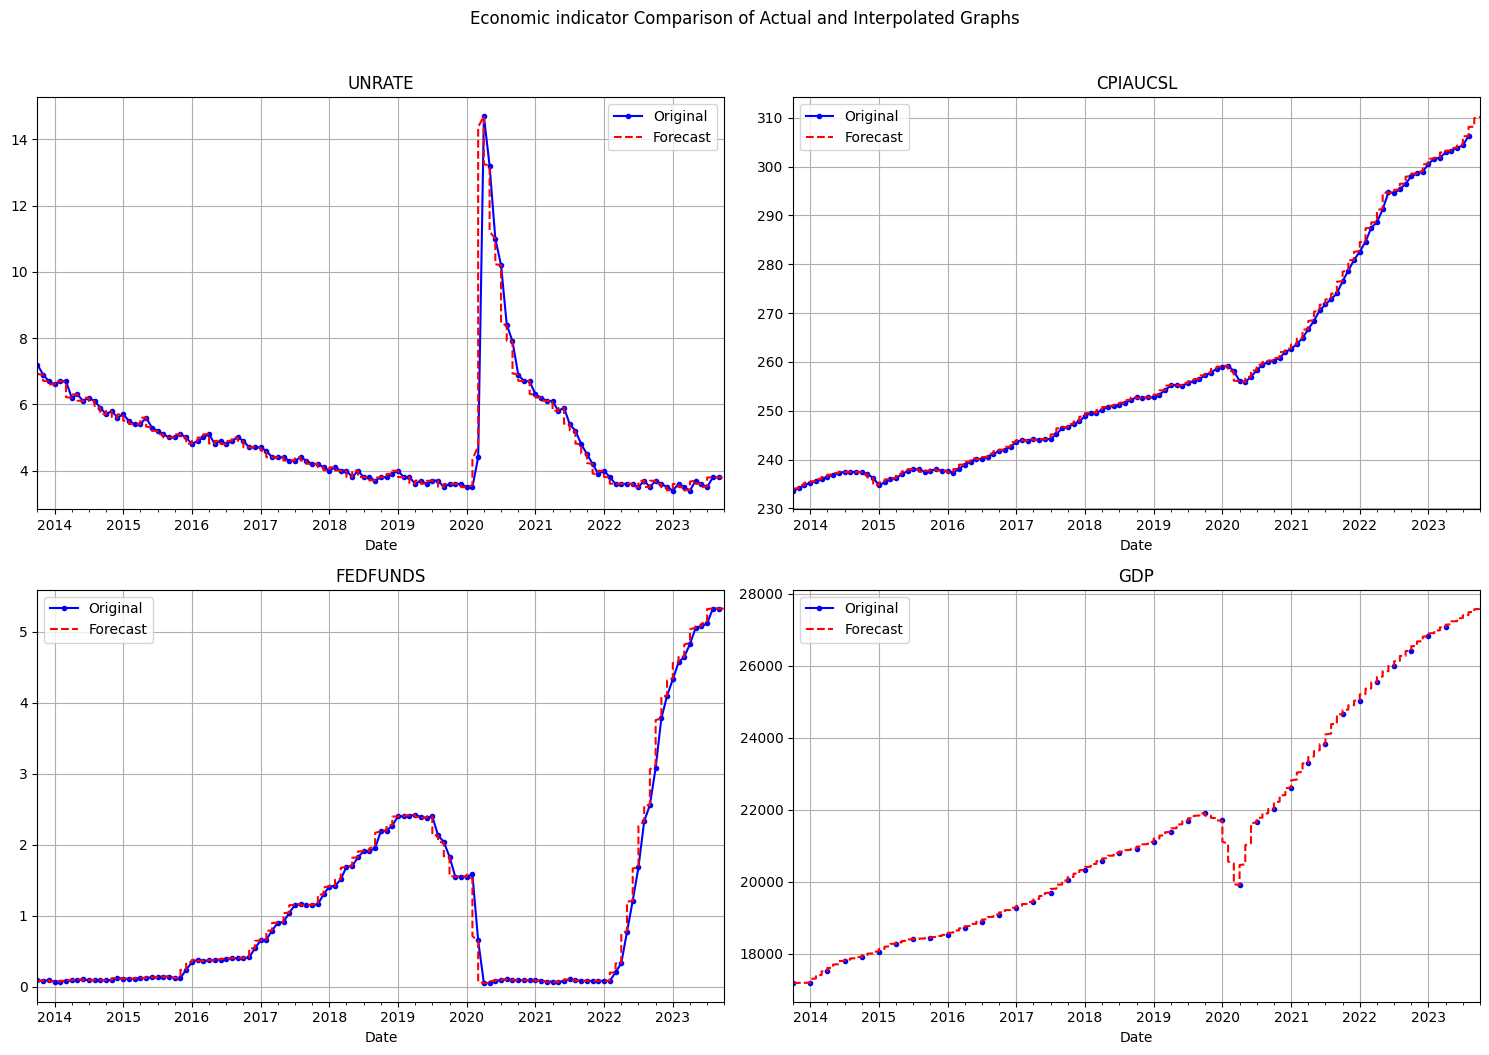

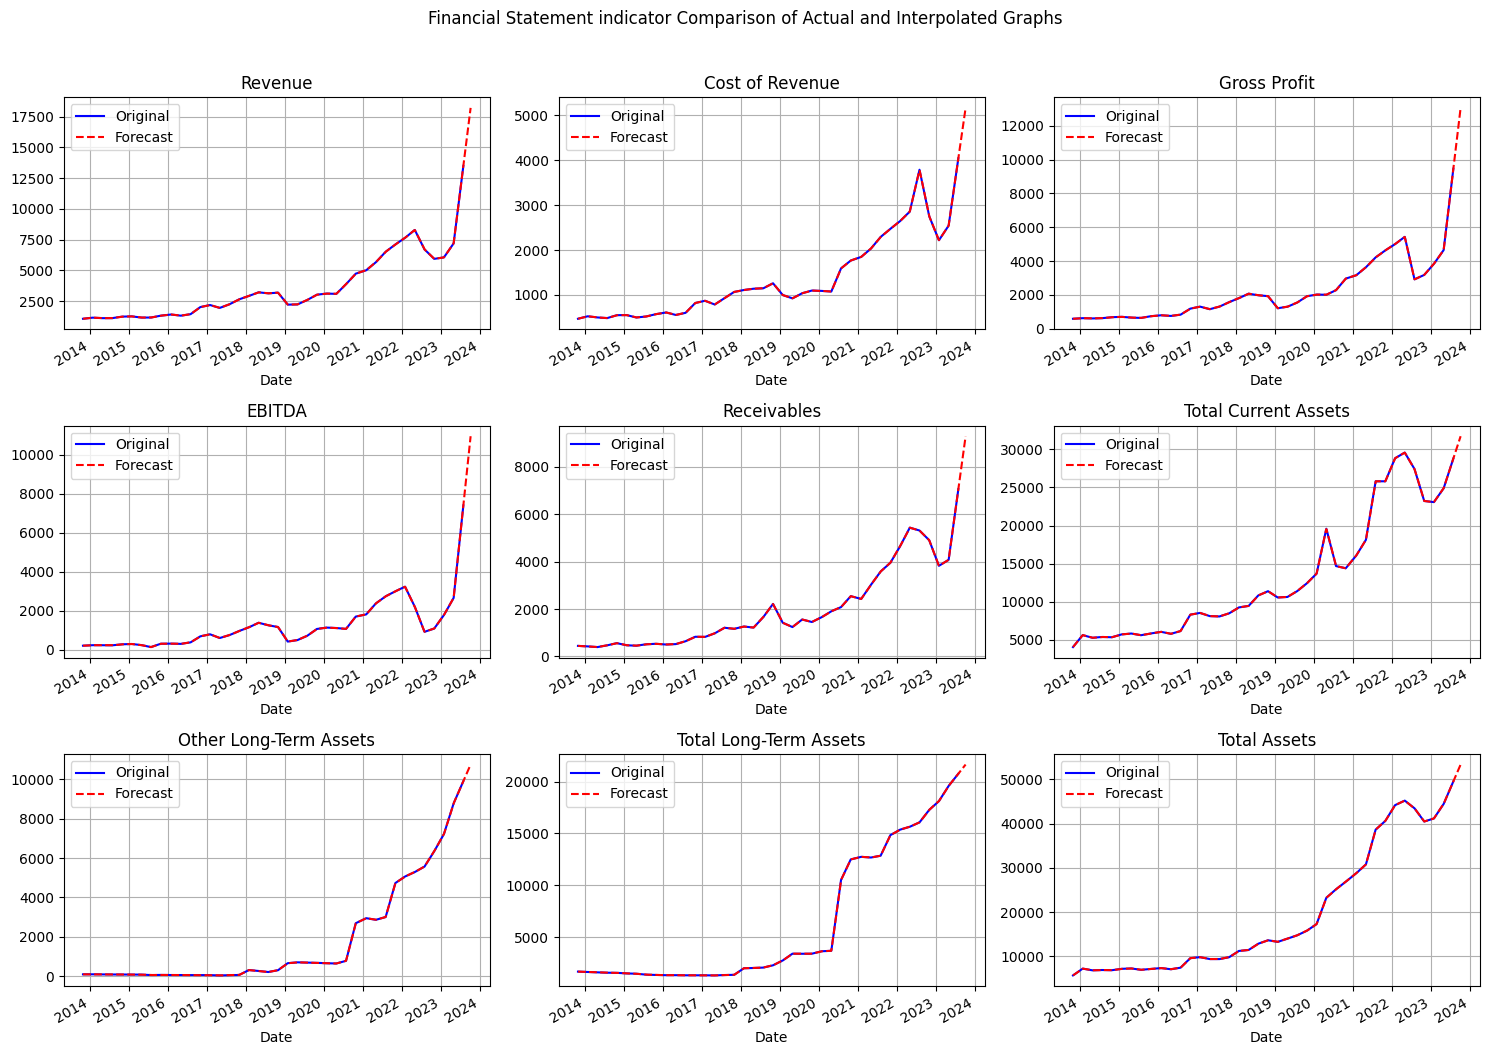

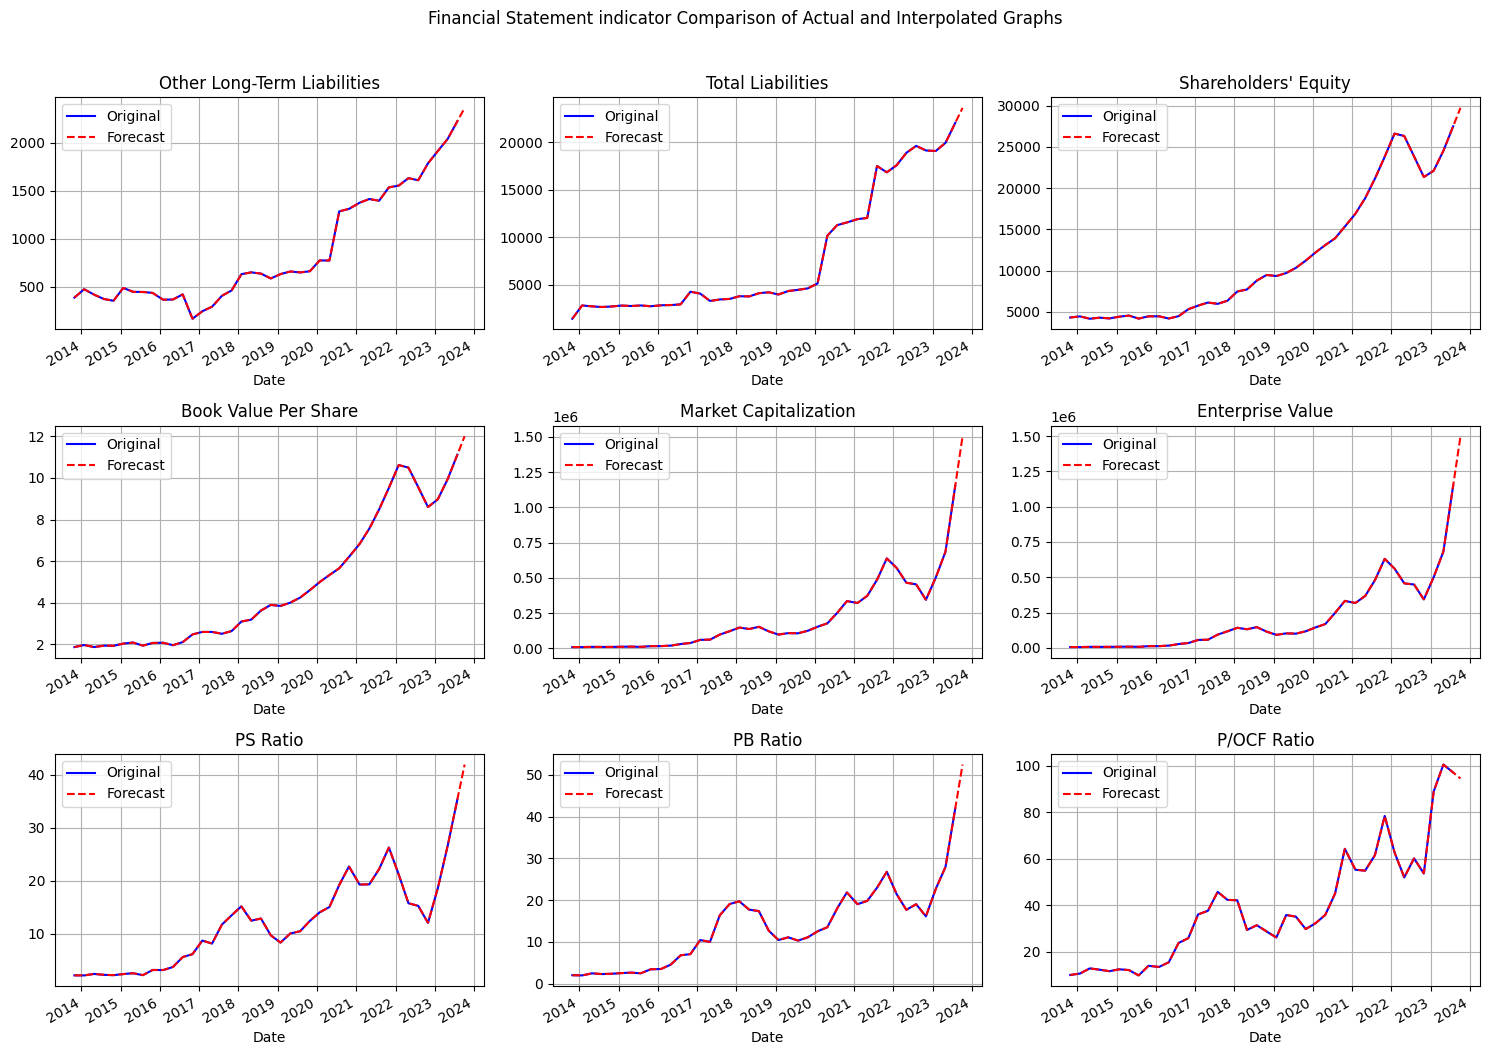

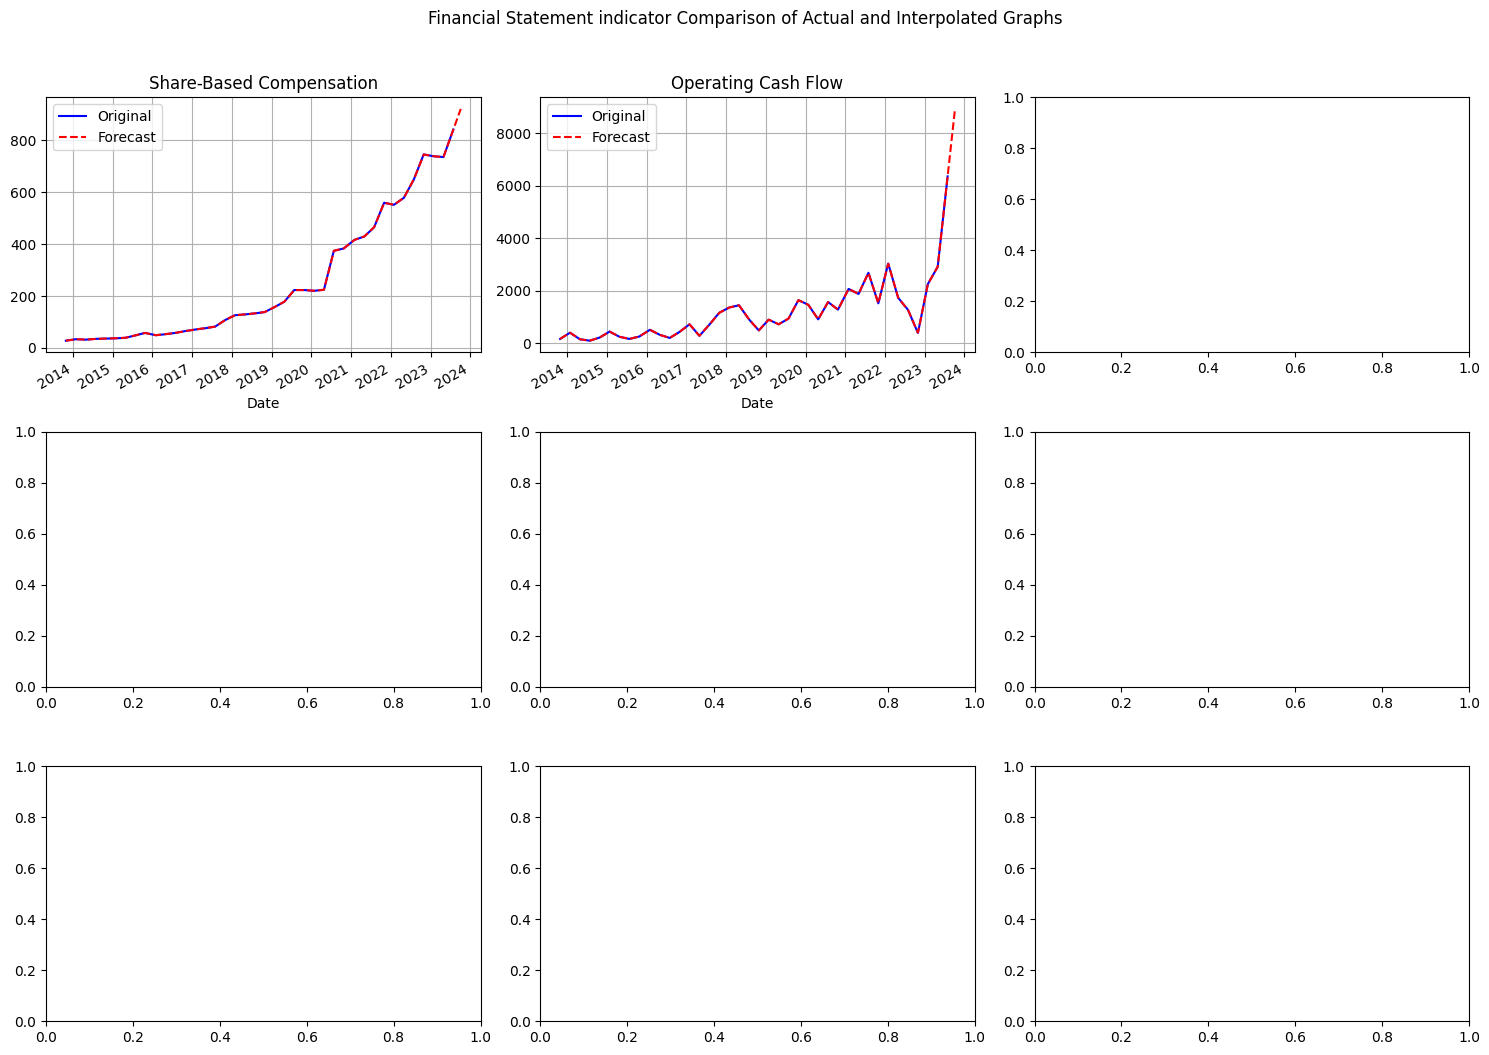

In [ ]:
# 1. Economic Indicators plot comparison
econ_month_df = Unemployment_Rate.join([CPI, FEDFUNDS, GDP], how='left')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
axes = axes.ravel()

for idx, column in enumerate(econ_month_df.columns):
    ax = axes[idx]
    econ_month_df[column].plot(ax=ax, label='Original', linestyle='-', color='blue', marker='o', ms=3)
    econ_df[column].plot(ax=ax, label='Forecast', linestyle='--', color='red')
    ax.set_title(column)
    ax.legend(loc='best')
    ax.grid(True)
plt.tight_layout()
plt.suptitle('Economic indicator Comparison of Actual and Interpolated Graphs', y=1.05)
plt.show()

# 2. Financial Statement Indicators plot comparison
common_columns = FS_Summary.columns.intersection(daily_FS_Summary.columns)
common_columns
page_size = 9
total_pages = -(-len(common_columns) // page_size)

for page in range(total_pages):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.ravel() 
    end_idx = min((page + 1) * page_size, len(common_columns))    
    for idx in range(page * page_size, end_idx):
        column = common_columns[idx]
        FS_Summary[column].plot(ax=axes[idx % page_size], label='Original', linestyle='-', color='blue')
        daily_FS_Summary[column].plot(ax=axes[idx % page_size], label='Forecast', linestyle='--', color='red')
        axes[idx % page_size].set_title(column)
        axes[idx % page_size].legend(loc='best')
        axes[idx % page_size].grid(True)
    plt.tight_layout()
    plt.suptitle('Financial Statement indicator Comparison of Actual and Interpolated Graphs', y=1.05)
    plt.show()


# 5. 변수들과 수정종가간의 상관관계 시각화 및 변수 선택

['Open', 'High', 'Low', 'Close', 'Adj Close', 'MA5', 'MA20', 'MA60', 'MA120', 'EMA5', 'EMA20', 'EMA60', 'EMA120', 'BOL_AVG', 'BOL_H1', 'BOL_L1', 'BOL_H2', 'BOL_L2']


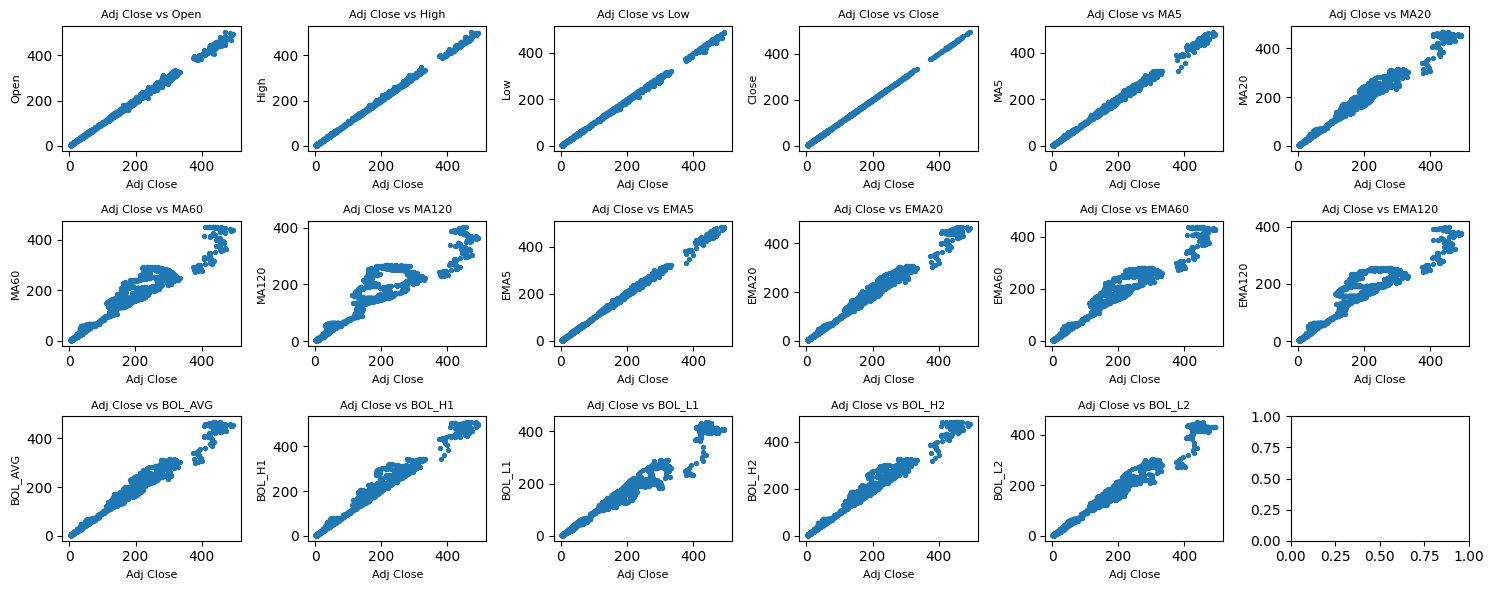

['Adj Close', 'CPIAUCSL', 'GDP']


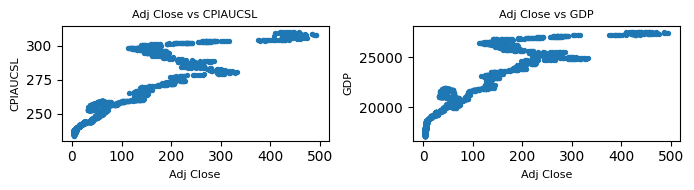

['Adj Close', 'Information Technology Adj Close']


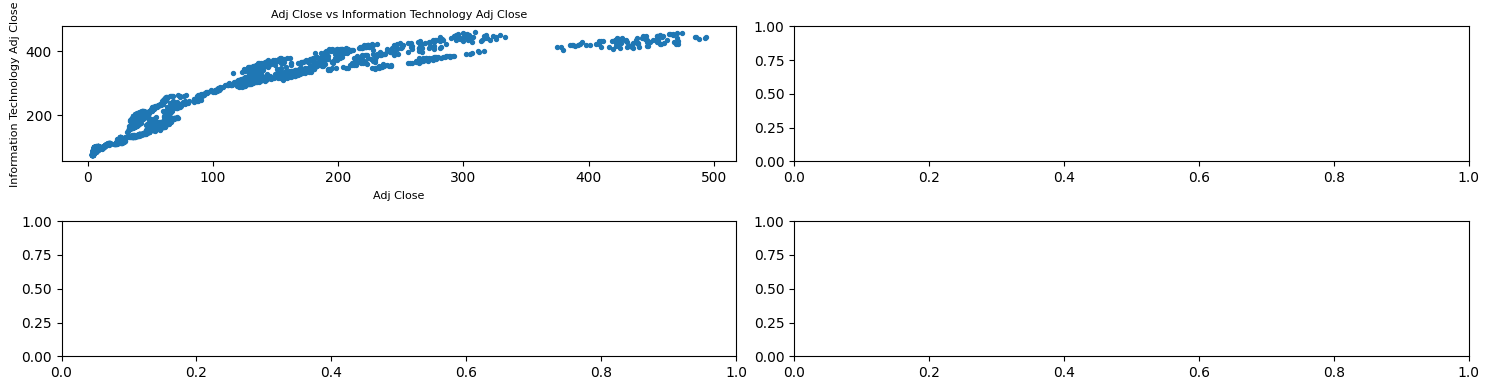

['Revenue', 'Cost of Revenue', 'Gross Profit', 'EBITDA', 'Receivables', 'Total Current Assets', 'Other Long-Term Assets', 'Total Long-Term Assets', 'Total Assets', 'Other Long-Term Liabilities', 'Total Liabilities', "Shareholders' Equity", 'Book Value Per Share', 'Market Capitalization', 'Enterprise Value', 'PS Ratio', 'PB Ratio', 'P/OCF Ratio', 'Share-Based Compensation', 'Operating Cash Flow', 'Adj Close']


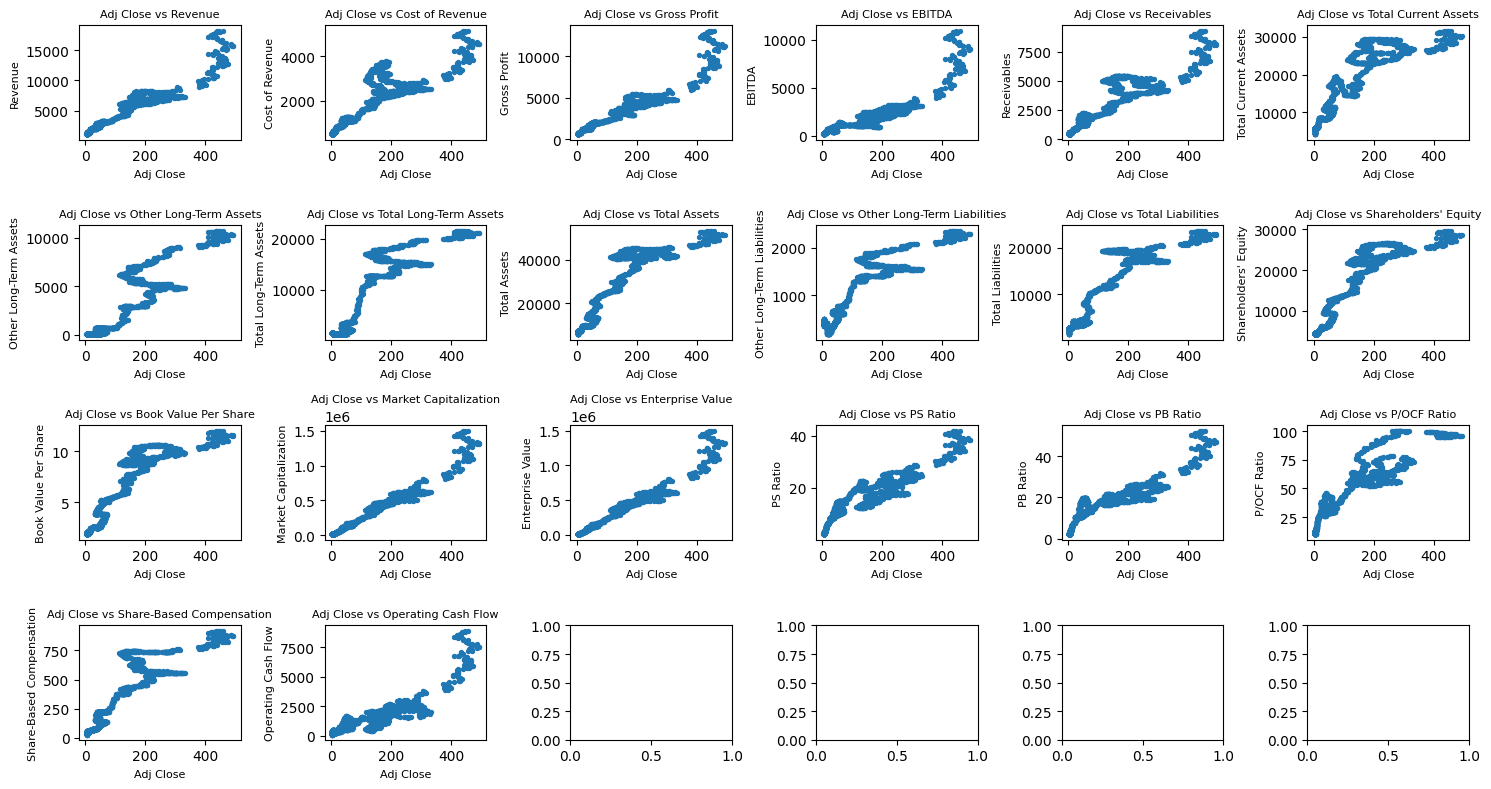

In [ ]:
### Technical Feature Selection

# 1.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = stock_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 1.2. Correlation Graph against Adj Close
ncols = 6  
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(stock_df['Adj Close'], stock_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 1.3. Select features based on high correlation
tech_df = stock_df[selected_features]


### Fundamental Feature Selection

## Economic Variable Selection
# 2.1. Filter features with a correlation coefficient of 0.8 or higher
correlation = econ_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.8].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 2.2. Correlation Graph against Adj Close
ncols = 2  
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(econ_df['Adj Close'], econ_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 2.3. Select features based on high correlation
econ_df = econ_df[selected_features]

## Industry Variable Selection
# 3.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = Industry_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 3.2.
ncols = 2  
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(Industry_df['Adj Close'], Industry_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 3.3. Select features based on high correlation
Industry_df = Industry_df[selected_features]

## Company Variable Selection
# 4.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 4.2.
ncols = 6  
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(daily_FS_Summary['Adj Close'], daily_FS_Summary[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 주가예측 분석

# 1. Technical Analysis - LSTM model

In [ ]:
## 1.1. Load data and Remove Missing value
df = tech_df

df = df.dropna()
df.isnull().sum() 

## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# Create feature_df, label_df 
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transform
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2384, 17)
label_np.shape:(2384, 1)


In [ ]:
## 1.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 


X.shape:(2354, 30, 17), Y.shape:(2354, 1)
x_train.shape:(1883, 30, 17), y_train.shape:(1883, 1)
x_test.shape:(471, 30, 17), y_test.shape:(471, 1)


In [ ]:
## 1.4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                20992     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
13/13 [==============================] - 1s 37ms/step - loss: 0.1353 - mae: 0.0835 - val_loss: 0.1173 - val_mae: 0.0629
Epoch 2/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.1081 - mae: 0.0341 - val_loss: 0.1013 - val_mae: 0.0498
Epoch 3/1000
13

## 1.2. Technical model Accuracy test

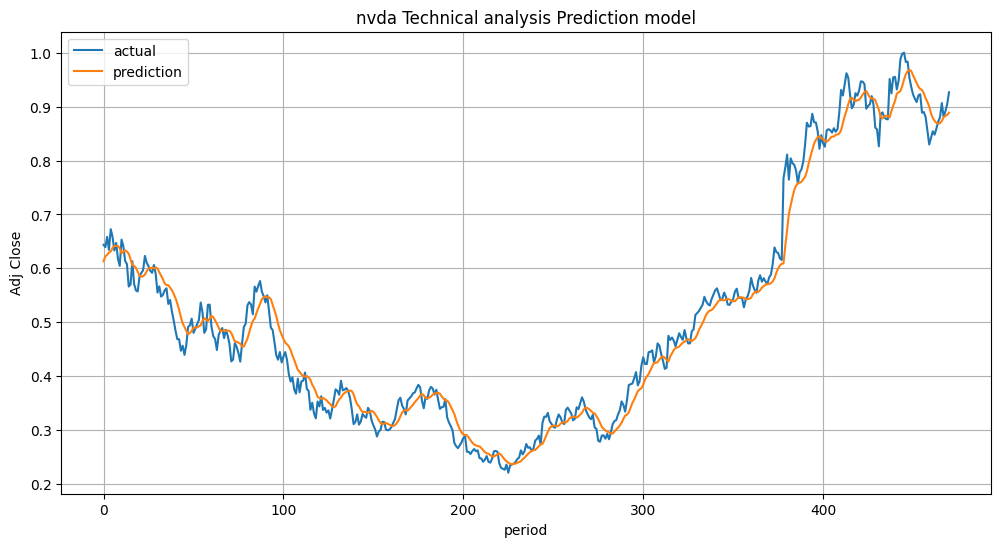

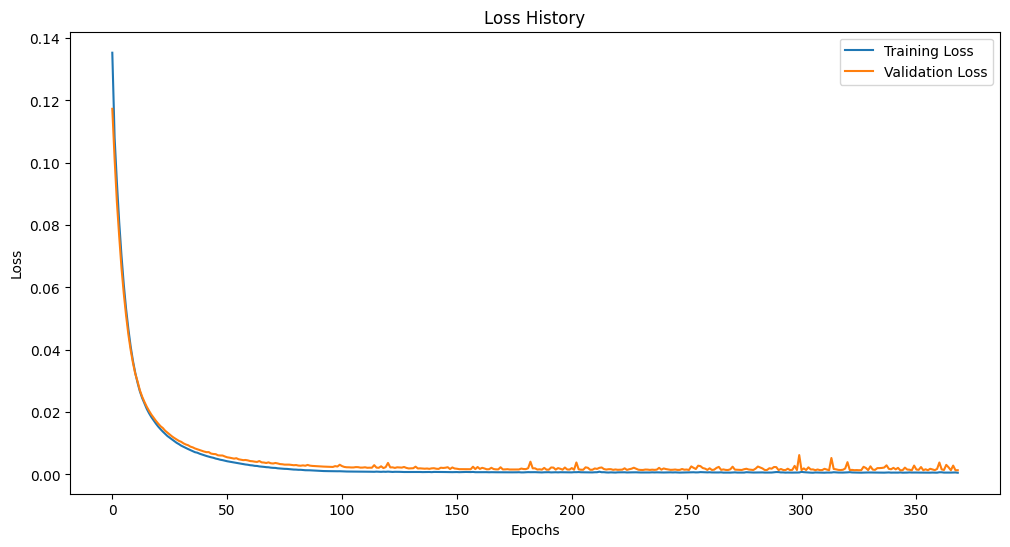

  Metrics    Values
0    MAPE  0.050673
1     MAE  0.023957
2    RMSE  0.031289


In [180]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Technical analysis Prediction model')
plt.ylabel('Adj Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()

# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation 2: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## 1.3. DataFrame for use as input to the Stacking model

In [181]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 1.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [182]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3)  
else:
    next_day = last_date + pd.Timedelta(days=1)  

# 1. Extract the last 30 days data
recent_feature = feature_np[-window_size:]
recent_feature = recent_feature.reshape(1, window_size, -1)

# 2. Predict the value for the next day
predicted_new = model.predict(recent_feature)

# 3. Inverse transform the predicted value to its original scale
dummy_data = np.zeros((1, scaled_df.shape[1] - 1))
predicted_new_full_features = np.hstack([predicted_new, dummy_data])

tech_predicted_new_original = scaler.inverse_transform(predicted_new_full_features)[0, 0]

1/1 [==============================] - 0s 13ms/step


# 2. Fundamental Analysis - LSTM model

In [183]:
## 2.1. Load data
df = econ_df
df2 = Industry_df.drop(columns=['Adj Close'])
df3 = daily_FS_Summary.drop(columns=['Adj Close'])

df = df.merge(df2, on='Date', how='left')
df = df.merge(df3, on='Date', how='left')

df = df.dropna()
df.isnull().sum() 

## 2.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# feature_df, label_df 생성
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transformation
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2503, 23)
label_np.shape:(2503, 1)


,Adj Close,CPIAUCSL,GDP,Information Technology Adj Close,Revenue,Cost of Revenue,Gross Profit,EBITDA,Receivables,Total Current Assets,...,Total Liabilities,Shareholders' Equity,Book Value Per Share,Market Capitalization,Enterprise Value,PS Ratio,PB Ratio,P/OCF Ratio,Share-Based Compensation,Operating Cash Flow
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-28,3.568404,234.044387,17193.697402,75.413116,1054.989011,470.154725,584.805275,205.313407,447.396264,4067.307692,...,1406.417582,4322.483516,1.861099,8.818308e+03,5.799209e+03,2.149890,2.039451,9.966923,27.982967,164.938132
2013-10-29,3.573096,234.058290,17193.759565,75.791016,1055.978022,470.759451,585.190549,205.596813,447.162527,4084.615385,...,1421.835165,4323.967033,1.862198,8.818615e+03,5.796418e+03,2.149780,2.038901,9.973846,28.045934,167.556264
2013-10-30,3.570750,234.072194,17193.821728,75.449066,1056.967033,471.364176,585.575824,205.880220,446.928791,4101.923077,...,1437.252747,4325.450549,1.863297,8.818923e+03,5.793626e+03,2.149670,2.038352,9.980769,28.108901,170.174396
2013-10-31,3.563712,234.086097,17193.883891,75.269142,1057.956044,471.968901,585.961099,206.163626,446.695055,4119.230769,...,1452.670330,4326.934066,1.864396,8.819231e+03,5.790835e+03,2.149560,2.037802,9.987692,28.171868,172.792527
2013-11-01,3.580135,234.100000,17193.946054,75.314133,1058.945055,472.573626,586.346374,206.447033,446.461319,4136.538462,...,1468.087912,4328.417582,1.865495,8.819538e+03,5.788044e+03,2.149451,2.037253,9.994615,28.234835,175.410659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,447.820007,310.111000,27573.566092,418.720001,17948.318681,5100.648352,12847.670330,10753.065934,9166.043956,31549.703297,...,23540.769231,29597.527473,11.956923,1.484800e+06,1.478222e+06,41.547143,51.864286,94.620659,915.549451,8765.230769
2023-10-03,435.170013,310.172968,27576.322534,410.760010,18017.714286,5117.142857,12900.571429,10805.285714,9198.857143,31592.714286,...,23564.000000,29630.285714,11.970000,1.489957e+06,1.483359e+06,41.644286,52.018571,94.582857,916.714286,8803.000000
2023-10-04,440.410004,310.234935,27579.125055,415.500000,18087.109890,5133.637363,12953.472527,10857.505495,9231.670330,31635.725275,...,23587.230769,29663.043956,11.983077,1.495115e+06,1.488496e+06,41.741429,52.172857,94.545055,917.879121,8840.769231


In [184]:
## 2.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)


# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 

X.shape:(2473, 30, 23), Y.shape:(2473, 1)
x_train.shape:(1978, 30, 23), y_train.shape:(1978, 1)
x_test.shape:(495, 30, 23), y_test.shape:(495, 1)


In [185]:
## 2.4. Construct and Compile model
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape, return_sequences=True,
               kernel_regularizer=L1L2(l1=0.001, l2=0.001), recurrent_regularizer=L1L2(l1=0.001, l2=0.001)))
               
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 128)           77824     
                                                                 
 dropout_18 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 127297 (497.25 KB)
Trainable params: 127297 (497.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000


## 2.2. Fundamental model Accuracy test

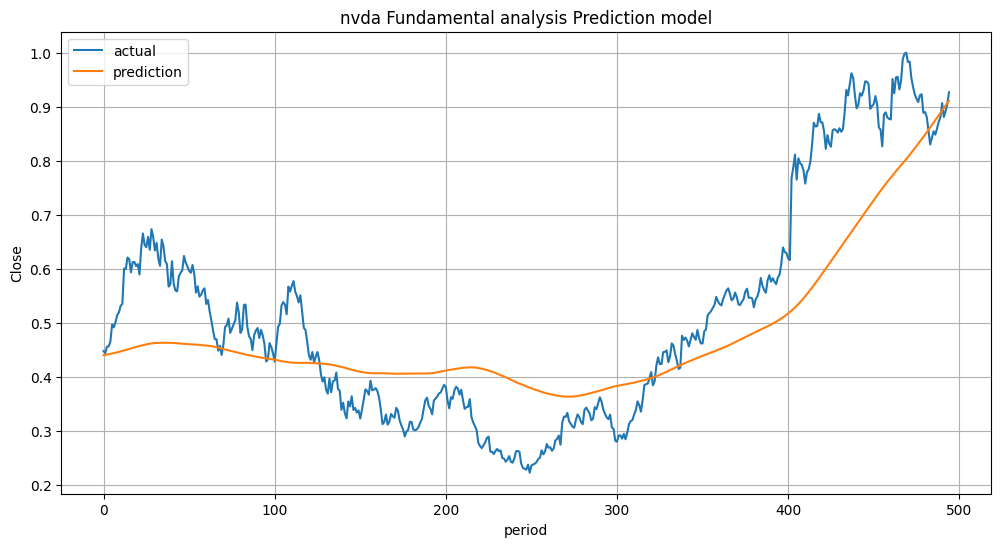

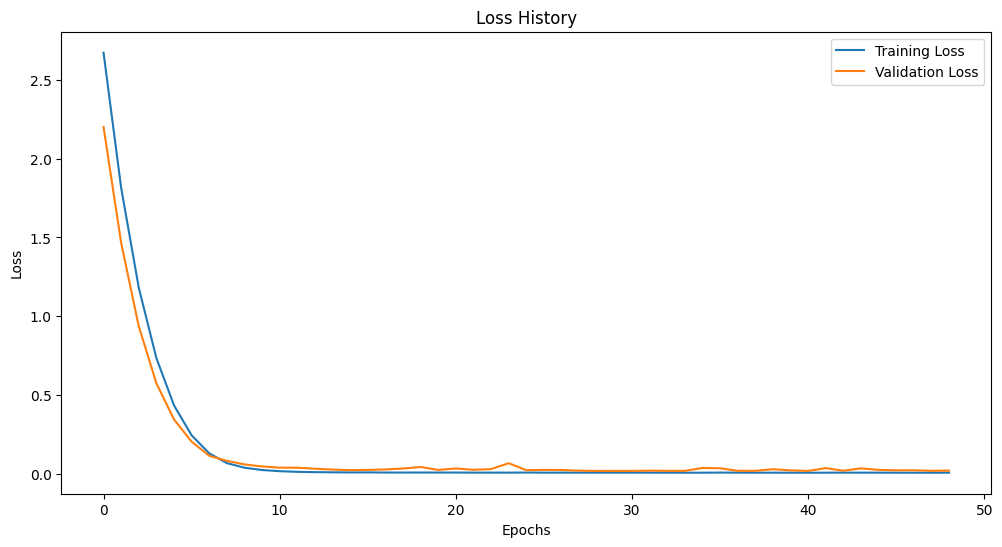

  Metrics    Values
0    MAPE  0.198885
1     MAE  0.095460
2    RMSE  0.117286


In [186]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Fundamental analysis Prediction model')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Evaluation 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## 2.3. DataFrame for use as input to the Stacking model

In [187]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

fund_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 2.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [188]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1) 

# 1. Extract the last 50 days data
latest_data = feature_np[-window_size:]
latest_data = latest_data.reshape(1, window_size, -1)

# 2. Predict the value for the next day
next_day_pred = model.predict(latest_data)

# 3. Inverse transform the predicted value to its original scale
inverse_df_temp = pd.DataFrame(np.zeros((1, len(scale_cols))), columns=scale_cols)  
inverse_df_temp['Adj Close'] = next_day_pred.flatten()
fund_predicted_new_original = scaler.inverse_transform(inverse_df_temp)[:, inverse_df_temp.columns.get_loc('Adj Close')]

# Convert numpy array value to scalar
fund_predicted_new_original = fund_predicted_new_original.item()

1/1 [==============================] - 0s 16ms/step


# 3. 최종예측을 위한 Stacking model 생성 (XGBoost, GridSearchCV)

## 3.1. 데이터 준비 및 전처리

In [189]:

# 1. Create dataframe based on each analysis result
df = pd.merge(tech_result_df[['Date', 'Real Price', 'Predicted Price']], 
                     fund_result_df[['Date', 'Predicted Price']],
                     on='Date', 
                     how='inner', 
                     suffixes=('_Tech', '_Fund'))

df.columns = ['Date', 'Real Price', 'Tech_Pred', 'Fund_Pred'] # Rename Column
df = df.set_index('Date').sort_index()

# 2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = ['Real Price', 'Tech_Pred', 'Fund_Pred']
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Create Feature/Label for Stacking model
X_stack = scaled_df[['Tech_Pred', 'Fund_Pred']].values
y_stack = scaled_df['Real Price'].values

# 3. Data split (20% test)
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.2, random_state=42)

print(f'X_train.shape:{X_train.shape}, X_val.shape:{X_val.shape}')
print(f'y_train.shape:{y_train.shape}, y_val.shape:{y_val.shape}') 


X_train.shape:(376, 2), X_val.shape:(95, 2)
y_train.shape:(376,), y_val.shape:(95,)


In [190]:
# 4. Meta model training using XGBoost with GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with best parameters
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
meta_model_xgb.fit(X_train, y_train)

y_pred = meta_model_xgb.predict(X_val)


Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.9}


## 3.2. Meta model result visualization

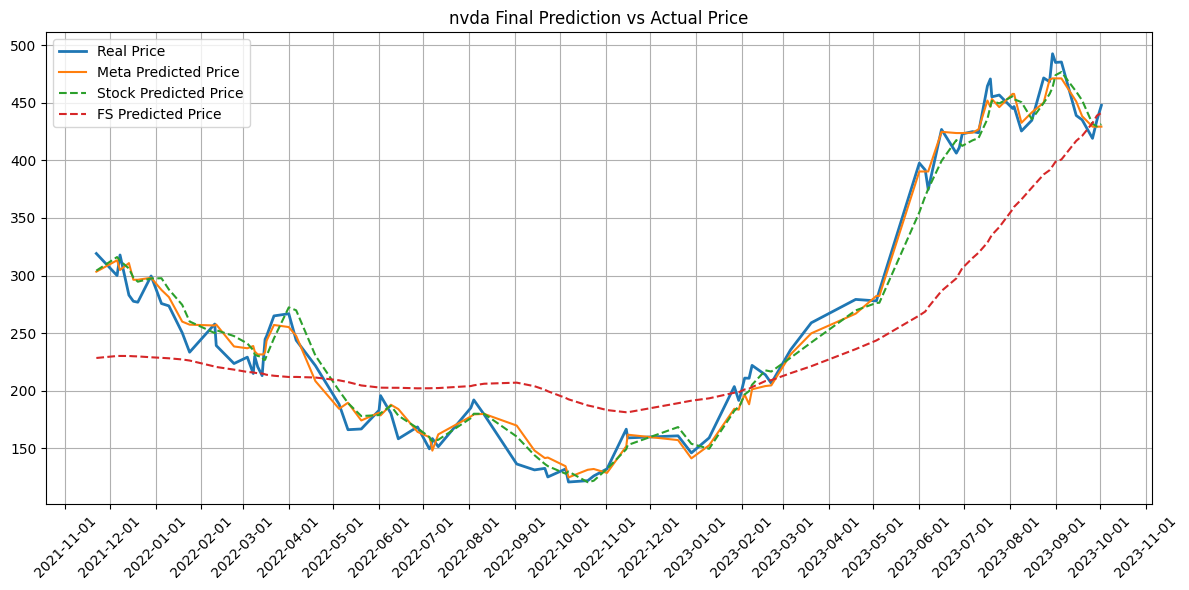

In [191]:
# Extracting predicted values from scaled data
y_val_original = scaler.inverse_transform(np.column_stack([y_val, np.zeros_like(y_val), np.zeros_like(y_val)]))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack([y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)]))[:, 0]
tech_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), X_val[:, 0], np.zeros_like(y_pred)]))[:, 1]
fund_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), np.zeros_like(y_pred), X_val[:, 1]]))[:, 2]

# Extracting date index
date_train, date_val = train_test_split(df.index, test_size=0.2, random_state=42)

# Prediction Graph
plot_df = pd.DataFrame({
    'Date': date_val,
    'Real Price': y_val_original,
    'Meta Predicted Price': y_pred_original,
    'Stock Predicted Price': tech_pred_original,
    'FS Predicted Price': fund_pred_original
})

plot_df = plot_df.sort_values(by='Date')
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Real Price'], label='Real Price', linewidth=2)
plt.plot(plot_df['Date'], plot_df['Meta Predicted Price'], label='Meta Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['Stock Predicted Price'], '--', label='Stock Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['FS Predicted Price'], '--', label='FS Predicted Price', linewidth=1.5)

ax = plt.gca() 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

plt.title(f"{ticker} Final Prediction vs Actual Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  


## 3.3. Meta model Accuracy Test

train_mse: 0.0005343639426805204, val_mse: 0.0011288080958556529


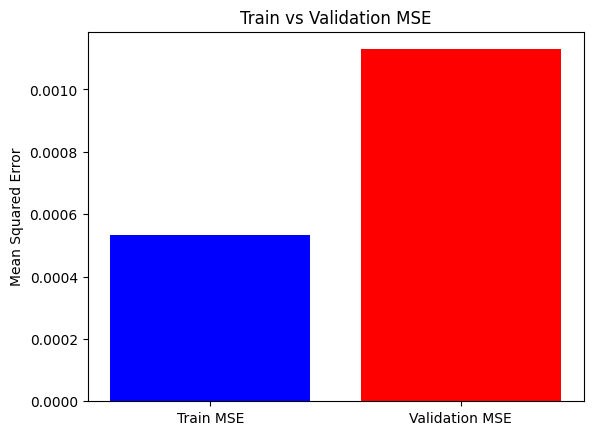

val_mse: 0.0011288080958556529, cross_val_mse: 0.0038495376297527305


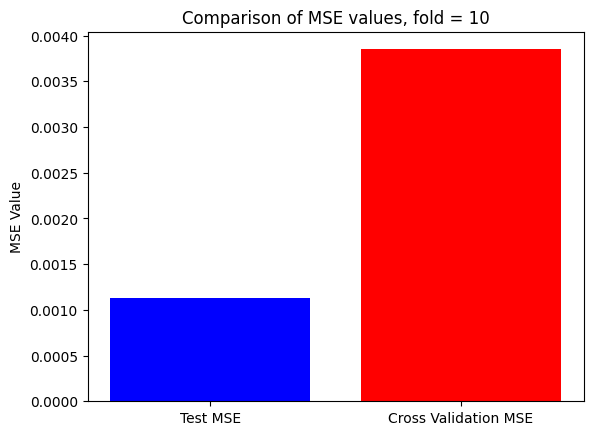

In [192]:
# 1. MSE Comparison Graph for train and validation set
y_train_pred = meta_model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_pred)
print( f'train_mse: {train_mse}, val_mse: {val_mse}')

plt.bar(['Train MSE', 'Validation MSE'], [train_mse, val_mse], color=['blue', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.show()

# 2.  MSE Comparison Graph using cross validation for validation and cv validation (fold =10)
cross_val_mse = -cross_val_score(meta_model_xgb, X_stack, y_stack, cv=10, scoring='neg_mean_squared_error').mean()
errors = [val_mse, cross_val_mse]
labels = ['Test MSE', 'Cross Validation MSE']
print( f'val_mse: {val_mse}, cross_val_mse: {cross_val_mse}')

plt.bar(labels, errors, color=['blue', 'red'])
plt.ylabel('MSE Value')
plt.title('Comparison of MSE values, fold = 10')
plt.show()

## 3.4. Predicting the actual price for the next day

In [193]:
# Predicted values for the next day obtained from the Technical and Fundamental models
next_day_tech_pred = tech_predicted_new_original  
next_day_fund_pred = fund_predicted_new_original 

next_day_tech_pred_scaled = scaler.transform([[0, next_day_tech_pred, 0]])[0][1]  
next_day_fund_pred_scaled = scaler.transform([[0, 0, next_day_fund_pred]])[0][2]  

# Predict with trained stacking model
next_day_meta_pred_scaled = meta_model_xgb.predict(np.array([[next_day_tech_pred_scaled, next_day_fund_pred_scaled]]))[0]
next_day_meta_pred = scaler.inverse_transform([[next_day_meta_pred_scaled, 0, 0]])[0][0]

# Print the date of the next day
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4: 
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1)  

print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Tech 예측 가격은: {next_day_tech_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Funda 예측 가격은: {next_day_fund_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 최종 예측 가격은: {next_day_meta_pred}") 

다음 날(2023-10-09)의 Tech 예측 가격은: 449.8834530104044
다음 날(2023-10-09)의 Funda 예측 가격은: 452.08835079947954
다음 날(2023-10-09)의 최종 예측 가격은: 427.5243633360597
